In [35]:
import numpy as np
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [36]:
#haar cascase in open cv helps to detect face, eyes and other parts
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

In [37]:
def get_cropped_image_if_2_eyes(image_path):
    if not os.path.exists(image_path): # Check if file exists
        print(f"Error: File not found -> {image_path}")
        return None
        
    img = cv2.imread(image_path)
    
    if img is None: # Check if image was loaded correctly
        print(f"Error: Unable to read image -> {image_path}")
        return None
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

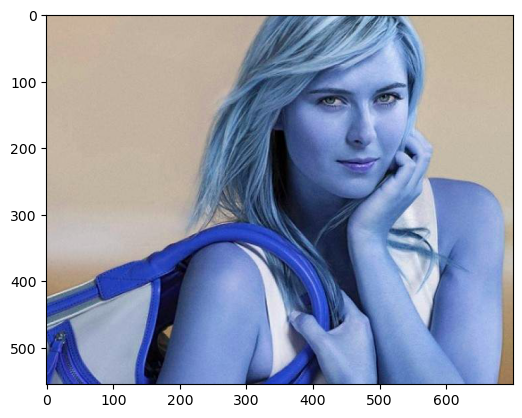

In [38]:
original_image = cv2.imread('./testImages/sharapova1.jpg')
plt.imshow(original_image)

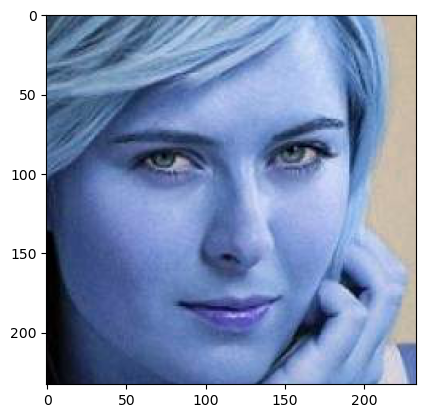

In [39]:
cropped_image = get_cropped_image_if_2_eyes('./testImages/sharapova1.jpg') #returns cropped picture if person detected(based on 2 eyes) otherwise None
plt.imshow(cropped_image) 

In [40]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [41]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [42]:
img_dirs

['./dataset/caleb',
 './dataset/charlie',
 './dataset/finn',
 './dataset/gaten',
 './dataset/joe',
 './dataset/millie',
 './dataset/natalie',
 './dataset/noah',
 './dataset/sadie']

In [43]:
import shutil #has high-level file operations
if os.path.exists(path_to_cr_data): #checks if path to code exists
    shutil.rmtree(path_to_cr_data) #recursively deletes the entire directory and its contents
os.mkdir(path_to_cr_data) #new empty directory

In [44]:
cropped_image_dirs = []
student_file_names_dict = {}

for img_dir in img_dirs: #iterates through directories in img_dirs
    count = 1 #to keep a track of how many cropped pictures in each cropped folder
    student_name = img_dir.split('/')[-1] #splits the path wrt / and returns last part...hence the name of student
    #print(student_name)

    student_file_names_dict[student_name] = []

    for entry in os.scandir(img_dir): #iterates through each file in directory
        if img_dir == './dataset/cropped': #prevents error while running file multiple times
            continue;
            
        roi_color = get_cropped_image_if_2_eyes(entry.path) #returns cropped pic, else None if no person detected
        if roi_color is not None:
            cropped_folder = path_to_cr_data + student_name
            if not os.path.exists(cropped_folder): #if folder does not exist 
                os.makedirs(cropped_folder) #make folder
                cropped_image_dirs.append(cropped_folder)

            cropped_file_name = student_name + str(count) + ".png" #so file name is saved as sepia1.png, sepia2.png, sepia3.png
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color) # adds the cropped pic(roi_color) to cropped folder
            
            #student_file_names_dict[student_name].append(cropped_file_path)
            count += 1              

Error: Unable to read image -> ./dataset/caleb\24px.svg
Error: Unable to read image -> ./dataset/caleb\download.gif
Error: Unable to read image -> ./dataset/caleb\mspin_googcolor_medium.svg
Error: Unable to read image -> ./dataset/caleb\RjSifSrhCjgL2rJpSSNX9Y.gif
Error: File not found -> ./dataset/caleb\westwood-los-angeles-ca-usa-october-26-caleb-mclaughlin-at-the-los-angeles-premiere-of-netflixs-stranger-things-season-2-held-at-the-westwood-village-theatre-on-october-26-2017-in-westwood-los-angeles-california-uni.jpg
Error: Unable to read image -> ./dataset/charlie\24px.svg
Error: Unable to read image -> ./dataset/charlie\download.gif
Error: Unable to read image -> ./dataset/charlie\mspin_googcolor_medium.svg
Error: Unable to read image -> ./dataset/charlie\Stranger-Things-star-Charlie-Heaton-responds-to-complaints-against-his-character-Jonathan-Byers’-storyline.jpg
Error: Unable to read image -> ./dataset/finn\24px.svg
Error: Unable to read image -> ./dataset/finn\download.gif
Error

In [45]:
#after manually going through and removing unwanted file

for img_dir in cropped_image_dirs:
    student_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    student_file_names_dict[student_name] = file_list
    
#student_file_names_dict

In [46]:
#Do Wavelet tranform of image to collect information about images
import pywt

def w2d(img, mode = 'haar', level = 1):
    imArray = img
    #Data conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray, cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    #Process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;

    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)

    return imArray_H

In [48]:
# print(student_file_names_dict)

In [55]:
#generate number for each student
class_dict = {}
count = 0
for student_name in student_file_names_dict.keys():
    class_dict[student_name] = count;
    count += 1
# class_dict

In [56]:
X = []
Y = []
for student_name, training_files in student_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
            
        scalled_raw_img = cv2.resize(img, (32,32)) #scales cropped image
        img_har = w2d(img, 'db1', 5) #perform wavelet transfom
        scalled_img_har = cv2.resize(img_har, (32,32)) #scale wavelet tranformed image
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1))) #vertically stack the images, as image classifier will require it in that manner. Colored and wavelet transformed images provide different info to classifier
        #                            32*32*3 is rgb channnel becoz colored image, 32*32 becoz gray image
        X.append(combined_img)
        Y.append(class_dict[student_name])        

In [57]:
len(X)
#len(X[0])

535

In [58]:
X = np.array(X).reshape(len(X), 4096).astype(float)
#X.shape

In [59]:
#TRAINING MODEL

In [60]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test)

0.746268656716418

In [62]:
print(classification_report(Y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.71      0.56      0.62         9
           2       0.81      0.87      0.84        15
           3       0.65      0.76      0.70        17
           4       0.77      0.62      0.69        16
           5       0.79      0.65      0.71        17
           6       0.75      0.80      0.77        15
           7       0.80      0.67      0.73        18
           8       0.67      0.82      0.74        17

    accuracy                           0.75       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.75      0.75      0.74       134



In [63]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [64]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [66]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.

,model,best_score,best_params
0,svm,0.698241,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.443889,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.698302,{'logisticregression__C': 1}


In [68]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [69]:
best_estimators['svm'].score(X_test,Y_test)

0.7835820895522388

In [70]:
best_estimators['random_forest'].score(X_test,Y_test)

0.417910447761194

In [71]:
best_estimators['logistic_regression'].score(X_test,Y_test)

0.746268656716418

In [81]:
best_clf = best_estimators['svm']

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, best_clf.predict(X_test))
cm

array([[10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  1,  0,  0,  0,  0,  0],
       [ 0,  1,  1, 13,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 13,  1,  0,  0,  2],
       [ 0,  0,  0,  1,  0,  9,  2,  1,  4],
       [ 0,  0,  0,  0,  1,  0, 11,  0,  3],
       [ 0,  1,  0,  2,  0,  0,  1, 13,  1],
       [ 1,  1,  0,  0,  0,  0,  0,  1, 14]], dtype=int64)

Text(58.222222222222214, 0.5, 'Truth')

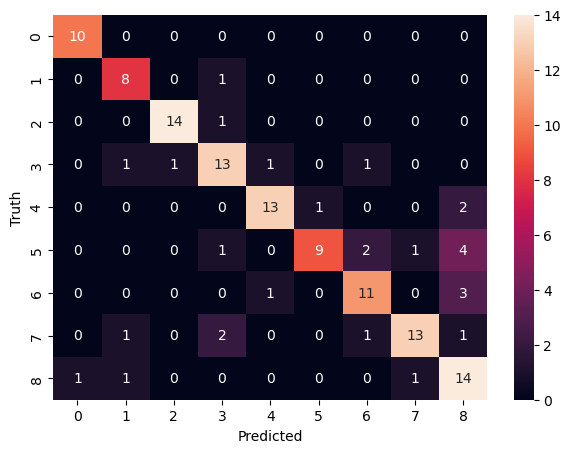

In [83]:
import seaborn as sn
plt.figure(figsize = (7,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [84]:
class_dict

{'caleb': 0,
 'charlie': 1,
 'finn': 2,
 'gaten': 3,
 'joe': 4,
 'millie': 5,
 'natalie': 6,
 'noah': 7,
 'sadie': 8}

In [85]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [86]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))